# Notebook Gruppe 5
## Bibliotheken importieren

In [7]:
%matplotlib notebook
import generator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow import keras
from ipywidgets import *

## Trainingsdaten initialisieren

In [2]:
dimension_count = 2
sensor_count = 3
sensors = generator.generate_targets(sensor_count, dimension_count)
targets = generator.generate_targets(60000, 2)
distances = generator.shitty_apply_sensors_on_targets(targets, sensors)


## Model kompilieren

In [3]:
model = keras.Sequential([
        keras.layers.Dense(20 * sensor_count, activation=tf.nn.relu, input_shape=(sensor_count,)),
        keras.layers.Dense(20 * sensor_count, activation=tf.nn.softmax),
        keras.layers.Dense(dimension_count)
    ])
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

## Model trainieren

In [4]:
model.fit(distances, targets, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.0174 - mean_absolute_error: 0.0640 - mean_squared_error: 0.0174
Epoch 2/10
60000/60000 [==============================] - 7s 110us/step - loss: 2.2698e-04 - mean_absolute_error: 0.0111 - mean_squared_error: 2.2698e-04
Epoch 3/10
60000/60000 [==============================] - 7s 113us/step - loss: 5.2535e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 5.2535e-05
Epoch 4/10
60000/60000 [==============================] - 6s 96us/step - loss: 1.5253e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.5253e-05
Epoch 5/10
60000/60000 [==============================] - 6s 105us/step - loss: 7.6836e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.6836e-06
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 5.0142e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0142e-06
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 3.7223

## Visualisierung
### Vorhergesagte Position vs tatsächliche Position
- Grüne Dreiecke ≙ Sensoren
- Blauer Kreis ≙ tatsächliche Position
    - Lässt sich festlegen durch Klicken des Diagramms
- Rotes Kreuz ≙ vorhergesagte Position

<IPython.core.display.Javascript object>


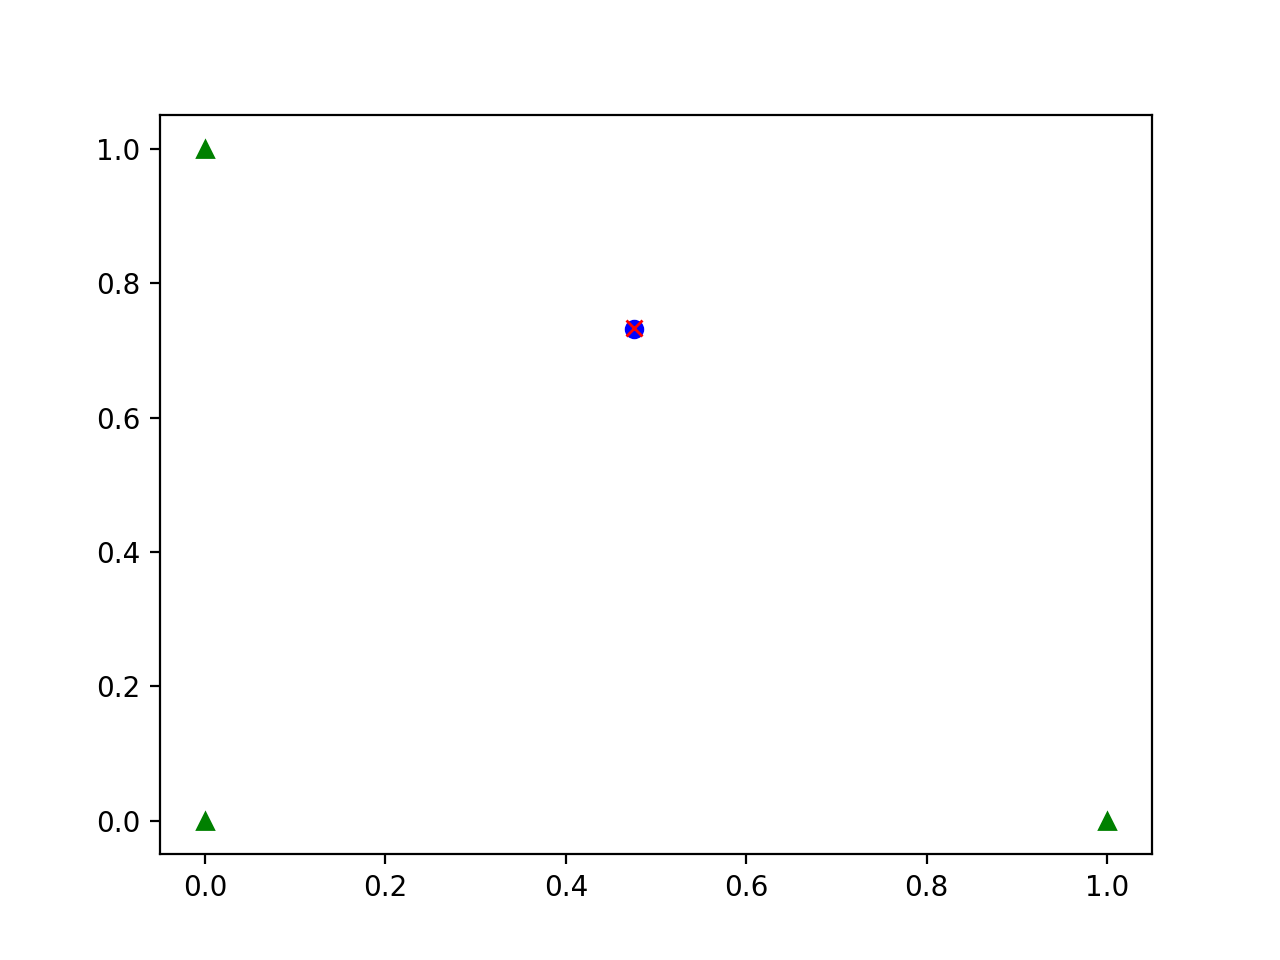

6

In [5]:
initial_target = np.array([0.5, 0.5])
initial_distance = generator.calculate_shitty_distances(initial_target, sensors)
initial_prediction = model.predict(np.array([initial_distance]))[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(sensors[:, 0], sensors[:, 1], "g^")
target_plot, = ax.plot(initial_target[0], initial_target[1], "bo")
prediction_plot, = ax.plot(initial_prediction[0], initial_prediction[1], "rx")


def update(x, y):
    target = np.array([x, y])
    distance = generator.calculate_shitty_distances(target, sensors)
    prediction = model.predict(np.array([distance]))[0]
    
    target_plot.set_xdata(target[0])
    target_plot.set_ydata(target[1])
    prediction_plot.set_xdata(prediction[0])
    prediction_plot.set_ydata(prediction[1])
    fig.canvas.draw()
    
    
def onclick(event):
    x, y = event.xdata, event.ydata
    if x >= 0.0 and x <= 1.0 and y >= 0.0 and y <= 1.0:
        update(event.xdata, event.ydata)

fig.canvas.mpl_connect('button_press_event', onclick)


[0.5, 0.5]
===== ERRORS - Deviation of the predicted target to the actual target =====
MAX: 0.41244533221301966
MIN: 0.0008528473971356194
AVG: 0.17349498516839168


<IPython.core.display.Javascript object>


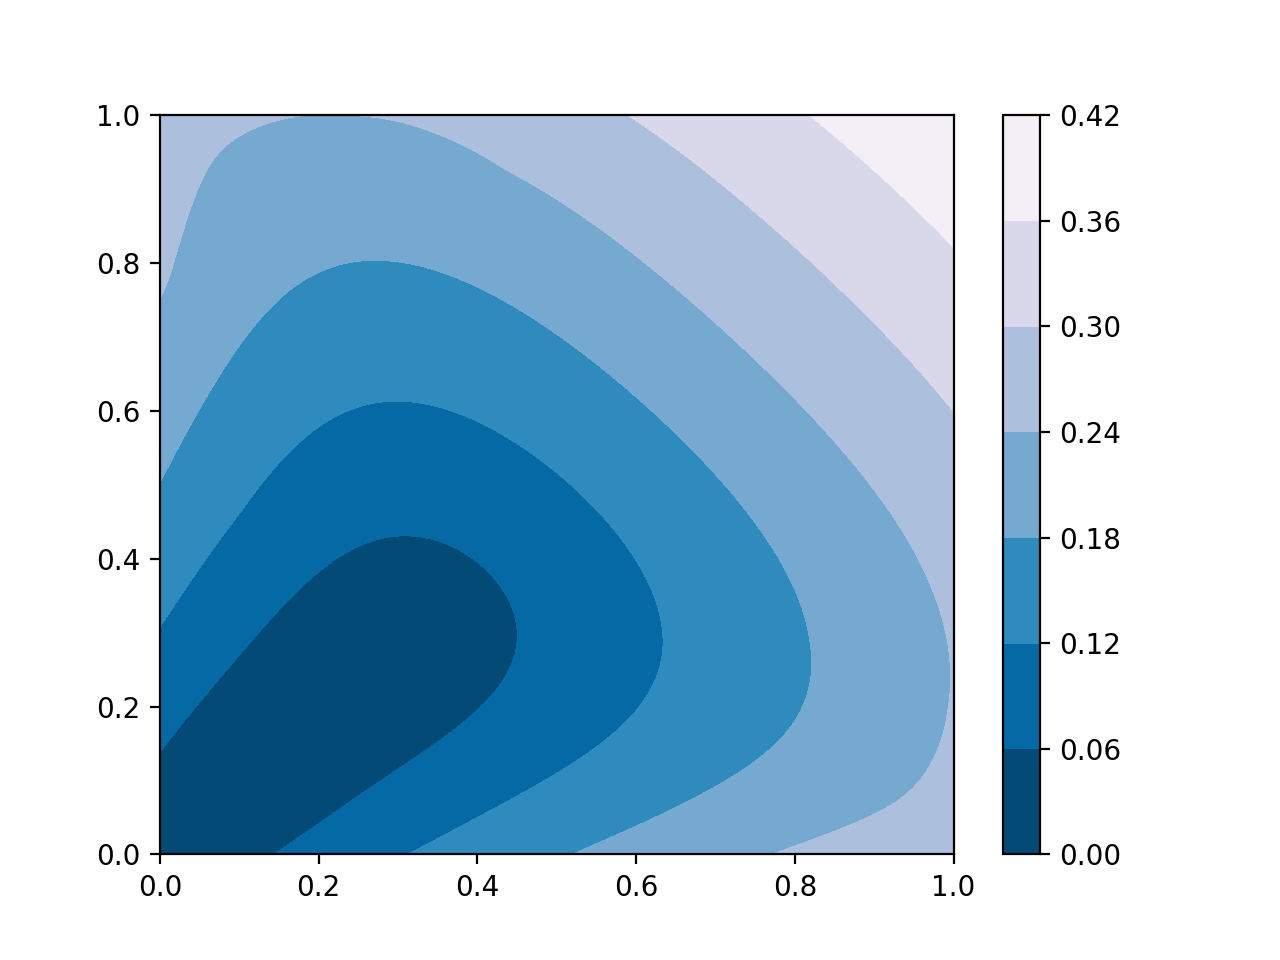

In [8]:
def visualize_error_interactive(model, sensors, size, dimension_count):
    """
    Draw a 2D-heatmap of prediction errors for a (size x size) grid.
    """

    def draw_plot(subplot, size, errors, cur_pos):
        if len(errors.shape) == 3:
            # Take 2D slice of 3D data
            errors = errors[:, :, int(cur_pos[2] * (size - 1))]

        subplot.clear()
        cont_plot = subplot.contourf(np.linspace(0.0, 1.0, size),
                                     np.linspace(0.0, 1.0, size),
                                     errors.transpose(), cmap=cm.PuBu_r)

        example_distances = np.array([
            generator.calculate_distances(np.array(cur_pos), sensors)
        ])
        prediction = model.predict(example_distances)[0]

        subplot.plot(
            cur_pos[0], cur_pos[1], "ko",
            prediction[0], prediction[1], "rx"
        )

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        subplot.axis([0.0, 1.0, 0.0, 1.0])

        fig.canvas.draw_idle()  # redraw the plot
        return cont_plot

    # Prepare data first
    targets, distances = \
        generator.generate_data_matrix(size, dimension_count, sensors)

    predictions = model.predict(distances)
    errors = np.zeros(predictions.shape[0])
    for i, _ in enumerate(predictions):
        errors[i] = np.linalg.norm(
            predictions[i] - targets[i])

    if dimension_count == 2:
        errors = np.reshape(errors, (size, size))
        cur_pos = [0.5, 0.5]
    elif dimension_count == 3:
        cur_pos = [0.5, 0.5, 0]
        errors = np.reshape(errors, (size, size, size))

    print(cur_pos)

    print("===== ERRORS - Deviation of the predicted target to the actual target =====")
    print("MAX:", errors.max())
    print("MIN:", errors.min())
    print("AVG:", errors.mean())
    print("==========")

    # Prepare Plot
    fig = plt.figure()
    plt.title('prediction (x) vs real position (o) + heatmap')
    subplot = fig.add_subplot(111)
    cont_plot = draw_plot(subplot, size, errors, cur_pos)
    fig.colorbar(cont_plot)

    # Define mouse interaction
    def onklick(event):
        cur_pos[0] = event.xdata
        cur_pos[1] = event.ydata

        draw_plot(subplot, size, errors, cur_pos)

    fig.canvas.mpl_connect('button_press_event', onklick)

    # Slider for z-axis if present
    if dimension_count == 3:
        slider_ax = plt.axes([0.125, 0.01, 0.78, 0.04])
        z_slider = Slider(ax=slider_ax, label="z",
                          valmin=0.0, valmax=1.0, valinit=0)

        def update(subplot, cur_pos, value):
            cur_pos[2] = value

            draw_plot(subplot, size, errors, cur_pos)

        z_slider.on_changed(lambda z_val: update(subplot, cur_pos, z_val))

    plt.show()
    
    
visualize_error_interactive(model, sensors, 100, dimension_count)